In [6]:
from typing import List, Dict, Tuple, Optional
import copy
from tqdm import tqdm

import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions as D

import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

## Model

In [3]:
class MLPPolicy(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_sizes: list,
        fixed_logstd: bool = False,
    ):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_sizes
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

        self.mean = nn.Sequential(
            nn.Linear(dims[-1], output_dim),
        )
        if fixed_logstd:
            self.log_std = nn.Parameter(torch.zeros(output_dim))
        else:
            self.log_std = nn.Sequential(
                nn.Linear(dims[-1], output_dim),
            )
        self.fixed_logstd = fixed_logstd

    def forward(self, state):
        common = self.net(state)
        mean = self.mean(common)
        log_std = self.log_std(common) if not self.fixed_logstd else self.log_std
        std = torch.exp(log_std)
        return mean, std

## fn

In [8]:
def compare_dist(
    policy: MLPPolicy,
    X: torch.tensor,
    y: torch.tensor,
    n_updates: int = 1,
    n_generations_grpo: int = 5,
    learning_rate: float = 0.001,
    sup_log_prob: bool = True,
    rsample_for_grpo: bool = False,
    RBF_gamma: Optional[float] = None,
):
    det_policy = copy.deepcopy(policy).train()
    supervised_policy = copy.deepcopy(policy).train()
    grpo_policy = copy.deepcopy(policy).train()

    det_optimizer = torch.optim.Adam(det_policy.parameters(), lr=learning_rate)
    supervised_optimizer = torch.optim.Adam(
        supervised_policy.parameters(), lr=learning_rate
    )
    grpo_optimizer = torch.optim.Adam(grpo_policy.parameters(), lr=learning_rate)

    # Pre-allocate arrays
    grpo = {
        "dist": [None] * n_updates,
        "samples": [None] * n_updates,
        "grad_norm": torch.zeros(n_updates),
        "mean_error": torch.zeros(n_updates),
        "loss": torch.zeros(n_updates),
        "NLL": torch.zeros(n_updates),
        "std1": torch.zeros(n_updates),
        "std2": torch.zeros(n_updates),
    }
    supervised = {
        "dist": [None] * n_updates,
        "grad_norm": torch.zeros(n_updates),
        "mean_error": torch.zeros(n_updates),
        "NLL": torch.zeros(n_updates),
        "std1": torch.zeros(n_updates),
        "std2": torch.zeros(n_updates),
    }
    det = {
        "grad_norm": torch.zeros(n_updates),
        "mean_error": torch.zeros(n_updates),
    }

    # train deterministic policy
    for i in range(n_updates):
        mean, _ = det_policy(X)
        # Only use mean for deterministic policy, ignore std
        loss = nn.MSELoss()(mean, y)

        det_optimizer.zero_grad()
        loss.backward()

        # compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(
            det_policy.parameters(), max_norm=1e9
        )
        det["grad_norm"][i] = grad_norm

        det_optimizer.step()

        det["mean_error"][i] = nn.MSELoss()(mean.mean(dim=0), y.mean(dim=0))

    # train supervised (maximum likelihood estimation)
    for i in range(n_updates):
        mean, std = supervised_policy(X)
        dist = torch.distributions.Normal(mean, std)
        if sup_log_prob:
            loss = -dist.log_prob(y).mean()
        else:
            pred = dist.rsample()
            loss = nn.MSELoss(reduction="none")(pred, y).mean(dim=-1)

        supervised_optimizer.zero_grad()
        loss.backward()

        supervised["NLL"][i] = loss.item()
        supervised["std1"][i] = std[0, 0].item()
        supervised["std2"][i] = std[0, 1].item()

        # compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(
            supervised_policy.parameters(), max_norm=1e9
        )
        supervised["grad_norm"][i] = grad_norm

        supervised_optimizer.step()

        supervised["dist"][i] = torch.distributions.Normal(
            mean[0].clone(), std[0].clone()
        )
        supervised["mean_error"][i] = nn.MSELoss()(mean.mean(dim=0), y.mean(dim=0))

    # train policy optimization
    for i in range(n_updates):
        mean, std = grpo_policy(X)
        dist = torch.distributions.Normal(mean, std)
        if rsample_for_grpo:
            samples = dist.rsample((n_generations_grpo,))
            # rewards
            rewards = -nn.MSELoss(reduction="none")(samples, y).mean(dim=-1)
            # rewards_min, rewards_max = rewards.aminmax(dim=0, keepdim=True)
            # rewards = (rewards - rewards_min) # / (rewards_max - rewards_min)
            # loss fn
            loss = -rewards.mean()
        else:
            samples = dist.sample((n_generations_grpo,))
            # likelihood
            neg_log_prob = -dist.log_prob(samples).mean(dim=-1)
            # rewards
            rewards = -nn.MSELoss(reduction="none")(samples, y).mean(dim=-1)
            if RBF_gamma:
                # RBF kernel for rewards
                rewards = torch.exp(-RBF_gamma * rewards)
            else:
                # normalize rewards
                rewards_min, _ = rewards.aminmax(dim=0, keepdim=True)
                rewards = rewards - rewards_min  # / (rewards_max - rewards_min)
            # loss fn
            loss = (neg_log_prob * rewards).mean()

        grpo_optimizer.zero_grad()
        loss.backward()

        grpo["loss"][i] = loss.item()
        grpo["NLL"][i] = -dist.log_prob(y).mean().item()
        grpo["std1"][i] = std[0, 0].item()
        grpo["std2"][i] = std[0, 1].item()

        # compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(
            grpo_policy.parameters(), max_norm=1e9
        )
        grpo["grad_norm"][i] = grad_norm

        grpo_optimizer.step()

        grpo["dist"][i] = torch.distributions.Normal(mean[0].clone(), std[0].clone())
        grpo["mean_error"][i] = nn.MSELoss()(mean.mean(dim=0), y.mean(dim=0))
        grpo["samples"][i] = samples.clone()

    return (det, supervised, grpo)

## Viz

### fn

In [5]:
def plot_distributions_comparison(
    init_dist,
    init_samples,
    supervised_dist,
    grpo_dist,
    samples,
    y,
    n_updates,
    ax,
    n_samples=1000,
    alpha_scatter=0.5,
    alpha_contour=0.3,
    contour_levels=4,
    scatter_size=10,
    samples_size=50,
    ground_truth_size=100,
    show_plot=True,
    save_path=None,
):
    """
    Plot comparison of initial, supervised learning, and GRPO distributions.

    Args:
        init_dist: Initial distribution (torch distribution)
        supervised_dist: Supervised learning distribution (torch distribution)
        grpo_dist: GRPO distribution (torch distribution)
        samples: GRPO samples tensor
        y: Ground truth tensor
        n_updates: Number of updates for title
        n_samples: Number of samples to plot for each distribution
        figsize: Figure size tuple
        alpha_scatter: Alpha for scatter plots
        alpha_contour: Alpha for contour plots
        contour_levels: Number of contour levels
        scatter_size: Size of distribution scatter points
        samples_size: Size of GRPO sample points
        ground_truth_size: Size of ground truth marker
        show_plot: Whether to show the plot
        save_path: Path to save the plot (optional)
    """

    # Plot initial distribution
    ax.scatter(
        init_samples[:, 0],
        init_samples[:, 1],
        c="blue",
        s=scatter_size,
        alpha=alpha_scatter,
        label="Initial Distribution",
    )

    # Generate grid for initial distribution contour
    x_range = np.linspace(np.min(init_samples[:, 0]), np.max(init_samples[:, 0]), 100)
    y_range = np.linspace(np.min(init_samples[:, 1]), np.max(init_samples[:, 1]), 100)
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    pos = np.dstack((X_grid, Y_grid))
    init_mean = init_dist.mean.detach().numpy().flatten()
    init_cov = torch.diag(init_dist.stddev.detach().flatten() ** 2).numpy()
    init_rv = multivariate_normal(init_mean, init_cov)
    ax.contour(
        X_grid,
        Y_grid,
        init_rv.pdf(pos),
        colors="blue",
        alpha=alpha_contour,
        levels=contour_levels,
    )

    # Plot supervised learning distribution
    sup_samples = supervised_dist.sample((n_samples,)).detach().numpy().squeeze()
    ax.scatter(
        sup_samples[:, 0],
        sup_samples[:, 1],
        c="green",
        s=scatter_size,
        alpha=alpha_scatter,
        label="Supervised Learning",
    )

    # Generate grid for supervised distribution contour
    x_range = np.linspace(np.min(sup_samples[:, 0]), np.max(sup_samples[:, 0]), 100)
    y_range = np.linspace(np.min(sup_samples[:, 1]), np.max(sup_samples[:, 1]), 100)
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    pos = np.dstack((X_grid, Y_grid))
    sup_mean = supervised_dist.mean.detach().numpy().flatten()
    sup_cov = torch.diag(supervised_dist.stddev.detach().flatten() ** 2).numpy()
    sup_rv = multivariate_normal(sup_mean, sup_cov)
    ax.contour(
        X_grid,
        Y_grid,
        sup_rv.pdf(pos),
        colors="green",
        alpha=alpha_contour,
        levels=contour_levels,
    )

    # Plot GRPO distribution
    grpo_samples = grpo_dist.sample((n_samples,)).detach().numpy().squeeze()
    ax.scatter(
        grpo_samples[:, 0],
        grpo_samples[:, 1],
        c="red",
        s=scatter_size,
        alpha=alpha_scatter,
        label="PO",
    )

    # Generate grid for GRPO distribution contour
    x_range = np.linspace(np.min(grpo_samples[:, 0]), np.max(grpo_samples[:, 0]), 100)
    y_range = np.linspace(np.min(grpo_samples[:, 1]), np.max(grpo_samples[:, 1]), 100)
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    pos = np.dstack((X_grid, Y_grid))
    grpo_mean = grpo_dist.mean.detach().numpy().flatten()
    grpo_cov = torch.diag(grpo_dist.stddev.detach().flatten() ** 2).numpy()
    grpo_rv = multivariate_normal(grpo_mean, grpo_cov)
    ax.contour(
        X_grid,
        Y_grid,
        grpo_rv.pdf(pos),
        colors="red",
        alpha=alpha_contour,
        levels=contour_levels,
    )

    # Plot GRPO samples
    # samples_np = samples.detach().numpy().reshape(-1, 2)
    # ax.scatter(
    #     samples_np[:, 0],
    #     samples_np[:, 1],
    #     c="orange",
    #     s=samples_size,
    #     alpha=0.99,
    #     label=f"PO Samples (n_gen={samples.shape[0]})",
    # )

    # Plot ground truth
    y_np = y.mean(dim=0).detach().numpy()
    ax.scatter(
        y_np[0],
        y_np[1],
        c="black",
        s=ground_truth_size,
        marker="*",
        label="Ground Truth",
    )
    for y_sample in y:
        y_sample_np = y_sample.detach().numpy()
        ax.scatter(
            y_sample_np[0],
            y_sample_np[1],
            c="black",
            s=ground_truth_size,
            marker="*",
            alpha=0.5,
        )

    # Set labels and title
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_title(f"PO Vs Supervised (n_updates={n_updates})")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
    ax.grid(True, alpha=0.3)

    # Set axis limits based on all samples
    all_samples = np.concatenate(
        [init_samples, y], axis=0
    )  # sup_samples, grpo_samples,
    ax.set_xlim(
        np.min(all_samples[:, 0]) - 1,
        np.max(all_samples[:, 0]) + 1,
    )
    ax.set_ylim(
        np.min(all_samples[:, 1]) - 1,
        np.max(all_samples[:, 1]) + 1,
    )

    plt.tight_layout()

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    # Show plot if requested
    if show_plot:
        plt.show()

    return ax


def plot_training_metrics(
    supervised_results,
    grpo_results,
    figsize=(15, 5),
    colors={"supervised": "green", "grpo": "red"},
    linewidth=2,
    marker_size=6,
    alpha=0.8,
    grid_alpha=0.3,
    show_plot=True,
    save_path=None,
    log_scale_grad=False,
    log_scale_error=False,
):
    """
    Plot gradient norm and mean error for supervised and GRPO training.

    Args:
        supervised_results: Dictionary containing supervised training results
        grpo_results: Dictionary containing GRPO training results
        figsize: Figure size tuple
        colors: Dictionary with colors for supervised and grpo lines
        linewidth: Line width for plots
        marker_size: Size of markers
        alpha: Line transparency
        grid_alpha: Grid transparency
        show_plot: Whether to show the plot
        save_path: Path to save the plot (optional)
        log_scale_grad: Whether to use log scale for gradient norm plot
        log_scale_error: Whether to use log scale for mean error plot

    Returns:
        fig, (ax1, ax2): matplotlib figure and axis objects
    """

    # Extract data
    supervised_grad_norm = supervised_results["grad_norm"]
    supervised_mean_error = supervised_results["mean_error"]
    grpo_grad_norm = grpo_results["grad_norm"]
    grpo_mean_error = grpo_results["mean_error"]

    # Convert tensors to numpy if needed
    if hasattr(supervised_mean_error[0], "detach"):
        supervised_mean_error = [
            x.detach().numpy() if hasattr(x, "detach") else x
            for x in supervised_mean_error
        ]
    if hasattr(grpo_mean_error[0], "detach"):
        grpo_mean_error = [
            x.detach().numpy() if hasattr(x, "detach") else x for x in grpo_mean_error
        ]

    # Create update indices
    n_updates_sup = len(supervised_grad_norm)
    n_updates_grpo = len(grpo_grad_norm)
    updates_sup = np.arange(1, n_updates_sup + 1)
    updates_grpo = np.arange(1, n_updates_grpo + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot gradient norm
    ax1.plot(
        updates_sup,
        supervised_grad_norm,
        color=colors["supervised"],
        linewidth=linewidth,
        marker="o",
        markersize=marker_size,
        alpha=alpha,
        label="Supervised",
    )
    ax1.plot(
        updates_grpo,
        grpo_grad_norm,
        color=colors["grpo"],
        linewidth=linewidth,
        marker="s",
        markersize=marker_size,
        alpha=alpha,
        label="GRPO",
    )

    ax1.set_xlabel("Update Step")
    ax1.set_ylabel("Gradient Norm")
    ax1.set_title("Gradient Norm vs Update Steps")
    ax1.legend()
    ax1.grid(True, alpha=grid_alpha)

    if log_scale_grad:
        ax1.set_yscale("log")

    # Plot mean error
    ax2.plot(
        updates_sup,
        supervised_mean_error,
        color=colors["supervised"],
        linewidth=linewidth,
        marker="o",
        markersize=marker_size,
        alpha=alpha,
        label="Supervised",
    )
    ax2.plot(
        updates_grpo,
        grpo_mean_error,
        color=colors["grpo"],
        linewidth=linewidth,
        marker="s",
        markersize=marker_size,
        alpha=alpha,
        label="GRPO",
    )

    ax2.set_xlabel("Update Step")
    ax2.set_ylabel("MSE")
    ax2.set_title("MSE vs Update Steps")
    ax2.legend()
    ax2.grid(True, alpha=grid_alpha)

    if log_scale_error:
        ax2.set_yscale("log")

    plt.tight_layout()

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    # Show plot if requested
    if show_plot:
        plt.show()

    return fig, (ax1, ax2)


def run_repeated_experiments(
    n_experiments: int,
    n_updates: int = 100,
    input_dim: int = 4,
    output_dim: int = 2,
    hidden_sizes: List[int] = [64, 64],
    seed: int = None,
    n_generations_grpo: int = 5,
    learning_rate: float = 0.001,
    sup_log_prob: bool = True,
    fixed_logstd: bool = False,
    init_dist_loc: float = 1.0,
    init_dist_scale: float = 0.1,
    init_dist_n_samples: int = 1,
    rsample_for_grpo: bool = False,
) -> Tuple[List[Dict], List[Dict]]:
    """
    Run the compare_dist experiment multiple times.

    Args:
        n_experiments: Number of experiments to run
        n_updates: Number of updates per experiment
        input_dim: Input dimension for the policy
        output_dim: Output dimension for the policy
        hidden_sizes: Hidden layer sizes for the policy
        seed: Random seed for reproducibility
        n_generations_grpo: Number of generations for GRPO
        learning_rate: Learning rate for optimizers
        sup_log_prob: Whether to use log probability for supervised learning

    Returns:
        supervised_results: List of supervised results from each experiment
        grpo_results: List of GRPO results from each experiment
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    det_results = []
    supervised_results = []
    grpo_results = []

    for i in tqdm(range(n_experiments), desc="n_experiments"):
        # Create new policy for each experiment
        policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

        # Generate new random data for each experiment
        X = torch.randn(1, input_dim)
        mean_y = 2 + torch.randn(1, output_dim) * init_dist_loc
        y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
        X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample

        # Run comparison
        det, supervised, grpo = compare_dist(
            policy=policy,
            n_updates=n_updates,
            X=X,
            y=y,
            n_generations_grpo=n_generations_grpo,
            learning_rate=learning_rate,
            sup_log_prob=sup_log_prob,
            rsample_for_grpo=rsample_for_grpo,
        )

        supervised_results.append(supervised)
        grpo_results.append(grpo)
        det_results.append(det)

    return (
        det_results,
        supervised_results,
        grpo_results,
    )


def extract_metrics_statistics(
    results_list: List[Dict], metric: str
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract mean, std, and confidence intervals for a specific metric.

    Args:
        results_list: List of result dictionaries from multiple experiments
        metric: Metric name ('grad_norm' or 'mean_error')

    Returns:
        mean_values: Mean values across experiments
        std_values: Standard deviation across experiments
        all_values: All values (n_experiments x n_updates)
    """
    # Convert to numpy arrays
    all_values = []
    for results in results_list:
        metric_values = results[metric]
        # Convert tensors to numpy if needed
        if hasattr(metric_values[0], "detach"):
            metric_values = [
                x.detach().numpy() if hasattr(x, "detach") else x for x in metric_values
            ]
        all_values.append(metric_values)

    # Convert to numpy array (n_experiments x n_updates)
    all_values = np.array(all_values)

    # Calculate statistics
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)

    return mean_values, std_values, all_values


def plot_training_metrics_with_confidence(
    results_dict: Dict[str, List[Dict]],
    confidence_level: float = 0.95,
    figsize: Tuple[float, float] = (18, 10),
    colors: Dict[str, str] = None,
    linewidth: float = 2,
    alpha_line: float = 1.0,
    alpha_fill: float = 0.3,
    grid_alpha: float = 0.3,
    save_path: str = None,
    log_scale_grad: bool = False,
    log_scale_error: bool = False,
    log_scale_nll: bool = False,
    log_scale_loss: bool = False,
    log_scale_std: bool = False,
    gt_std: float = 0.1,
):
    """
    Plot training metrics with confidence bounds from multiple experiments.

    Args:
        results_dict: Dictionary with method names as keys and lists of results as values
        confidence_level: Confidence level for bounds (e.g., 0.95 for 95%)
        figsize: Figure size tuple
        colors: Dictionary with colors for each method (auto-generated if None)
        linewidth: Line width for mean lines
        alpha_line: Alpha for mean lines
        alpha_fill: Alpha for confidence intervals
        grid_alpha: Grid transparency
        save_path: Path to save the plot (optional)
        log_scale_grad: Whether to use log scale for gradient norm plot
        log_scale_error: Whether to use log scale for mean error plot
        log_scale_nll: Whether to use log scale for NLL plot
        log_scale_loss: Whether to use log scale for loss plot
        log_scale_std: Whether to use log scale for std plot
        gt_std: groundtruth std

    Returns:
        fig, axes: matplotlib figure and axis objects (2x3 grid)
    """
    # Default colors if not provided
    if colors is None:
        color_cycle = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))
        colors = {
            method: color for method, color in zip(results_dict.keys(), color_cycle)
        }

    # Calculate confidence interval multiplier
    from scipy import stats

    alpha = 1 - confidence_level
    n_experiments = len(next(iter(results_dict.values())))
    t_value = stats.t.ppf(1 - alpha / 2, n_experiments - 1)

    # Extract statistics for all metrics and methods
    metrics_data = {}
    for method_name, results_list in results_dict.items():
        metrics_data[method_name] = {}

        # Check which metrics exist for this method
        available_metrics = set()
        if results_list:
            available_metrics = set(results_list[0].keys())

        for metric in ["mean_error", "NLL", "loss", "grad_norm", "std1", "std2"]:
            if metric in available_metrics:
                mean_values, std_values, all_values = extract_metrics_statistics(
                    results_list, metric
                )
                ci_values = t_value * std_values / np.sqrt(n_experiments)
                metrics_data[method_name][metric] = {
                    "mean": mean_values,
                    "std": std_values,
                    "ci": ci_values,
                    "all": all_values,
                }

    # Create update indices (use the first method with mean_error to determine length)
    n_updates = None
    for method_data in metrics_data.values():
        if "mean_error" in method_data:
            n_updates = len(method_data["mean_error"]["mean"])
            break

    if n_updates is None:
        raise ValueError("No method has 'mean_error' metric to determine n_updates")

    updates = np.arange(1, n_updates + 1)

    # Create subplots in 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    ax1, ax2, ax3 = axes[0]  # First row: MSE, NLL, Loss
    ax4, ax5, ax6 = axes[1]  # Second row: Grad norm, std1, std2

    # Plot MSE (first row, first column)
    for method_name, method_data in metrics_data.items():
        if "mean_error" in method_data:
            data = method_data["mean_error"]
            ax1.plot(
                updates,
                data["mean"],
                color=colors[method_name],
                linewidth=linewidth,
                alpha=alpha_line,
                label=f"{method_name} (n={n_experiments})",
            )
            ax1.fill_between(
                updates,
                data["mean"] - data["ci"],
                data["mean"] + data["ci"],
                color=colors[method_name],
                alpha=alpha_fill,
            )

    ax1.set_xlabel("Update Step")
    ax1.set_ylabel("MSE")
    ax1.set_title(f"MSE ({confidence_level * 100:.0f}% CI)")
    ax1.grid(True, alpha=grid_alpha)
    if log_scale_error:
        ax1.set_yscale("log")

    # Plot NLL (first row, second column)
    for method_name, method_data in metrics_data.items():
        if "NLL" in method_data:
            data = method_data["NLL"]
            ax2.plot(
                updates,
                data["mean"],
                color=colors[method_name],
                linewidth=linewidth,
                alpha=alpha_line,
                label=f"{method_name} (n={n_experiments})",
            )
            ax2.fill_between(
                updates,
                data["mean"] - data["ci"],
                data["mean"] + data["ci"],
                color=colors[method_name],
                alpha=alpha_fill,
            )

    ax2.set_xlabel("Update Step")
    ax2.set_ylabel("NLL")
    ax2.set_title("NLL")
    ax2.grid(True, alpha=grid_alpha)
    if log_scale_nll:
        ax2.set_yscale("log")

    # Plot Loss (first row, third column)
    for method_name, method_data in metrics_data.items():
        if "loss" in method_data:
            data = method_data["loss"]
            ax3.plot(
                updates,
                data["mean"],
                color=colors[method_name],
                linewidth=linewidth,
                alpha=alpha_line,
                label=f"{method_name} (n={n_experiments})",
            )
            ax3.fill_between(
                updates,
                data["mean"] - data["ci"],
                data["mean"] + data["ci"],
                color=colors[method_name],
                alpha=alpha_fill,
            )

    ax3.set_xlabel("Update Step")
    ax3.set_ylabel("Loss")
    ax3.set_title("Loss")
    ax3.grid(True, alpha=grid_alpha)
    if log_scale_loss:
        ax3.set_yscale("log")

    # Plot gradient norm (second row, first column)
    for method_name, method_data in metrics_data.items():
        if "grad_norm" in method_data:
            data = method_data["grad_norm"]
            ax4.plot(
                updates,
                data["mean"],
                color=colors[method_name],
                linewidth=linewidth,
                alpha=alpha_line,
                label=f"{method_name} (n={n_experiments})",
            )
            ax4.fill_between(
                updates,
                data["mean"] - data["ci"],
                data["mean"] + data["ci"],
                color=colors[method_name],
                alpha=alpha_fill,
            )

    ax4.set_xlabel("Update Step")
    ax4.set_ylabel("Gradient Norm")
    ax4.set_title("Gradient Norm")
    ax4.grid(True, alpha=grid_alpha)
    if log_scale_grad:
        ax4.set_yscale("log")

    # Plot std1 (second row, second column)
    for method_name, method_data in metrics_data.items():
        if "std1" in method_data:
            data = method_data["std1"]
            ax5.plot(
                updates,
                data["mean"],
                color=colors[method_name],
                linewidth=linewidth,
                alpha=alpha_line,
                label=f"{method_name} (n={n_experiments})",
            )
            ax5.fill_between(
                updates,
                data["mean"] - data["ci"],
                data["mean"] + data["ci"],
                color=colors[method_name],
                alpha=alpha_fill,
            )

    ax5.axhline(
        y=gt_std, color="black", linestyle="--", alpha=0.7, label="Groundtruth Std"
    )
    ax5.set_xlabel("Update Step")
    ax5.set_ylabel("Standard Deviation")
    ax5.set_title("Std Dimension 1")
    ax5.grid(True, alpha=grid_alpha)
    if log_scale_std:
        ax5.set_yscale("log")

    # Plot std2 (second row, third column)
    for method_name, method_data in metrics_data.items():
        if "std2" in method_data:
            data = method_data["std2"]
            ax6.plot(
                updates,
                data["mean"],
                color=colors[method_name],
                linewidth=linewidth,
                alpha=alpha_line,
                label=f"{method_name} (n={n_experiments})",
            )
            ax6.fill_between(
                updates,
                data["mean"] - data["ci"],
                data["mean"] + data["ci"],
                color=colors[method_name],
                alpha=alpha_fill,
            )

    ax6.axhline(
        y=gt_std, color="black", linestyle="--", alpha=0.7, label="Groundtruth Std"
    )
    ax6.set_xlabel("Update Step")
    ax6.set_ylabel("Standard Deviation")
    ax6.set_title("Std Dimension 2")
    ax6.grid(True, alpha=grid_alpha)
    if log_scale_std:
        ax6.set_yscale("log")

    # Add single legend centered below all plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=3)

    plt.tight_layout()

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return fig, axes

### multiple simulations

In [46]:
# Experiment parameters
n_experiments = 10  # Number of repetitions
n_updates = 100
input_dim = 4
output_dim = 2
hidden_sizes = [64, 64]

fixed_logstd = False
init_dist_loc = 1.0
init_dist_scale = 0.1
init_dist_n_samples = 1
rsample_for_grpo = False

# Run repeated experiments
print(f"Running {n_experiments} experiments...")
det_results_list, supervised_results_list, grpo_results_list = run_repeated_experiments(
    n_experiments=n_experiments,
    n_updates=n_updates,
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_sizes=hidden_sizes,
    seed=42,
    sup_log_prob=True,
    fixed_logstd=fixed_logstd,
    n_generations_grpo=25,
    init_dist_loc=init_dist_loc,
    init_dist_scale=init_dist_scale,
    init_dist_n_samples=init_dist_n_samples,
    rsample_for_grpo=rsample_for_grpo,
)

Running 10 experiments...


n_experiments:   0%|          | 0/10 [00:00<?, ?it/s]/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([25, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
n_experiments: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


Plotting results with confidence bounds...


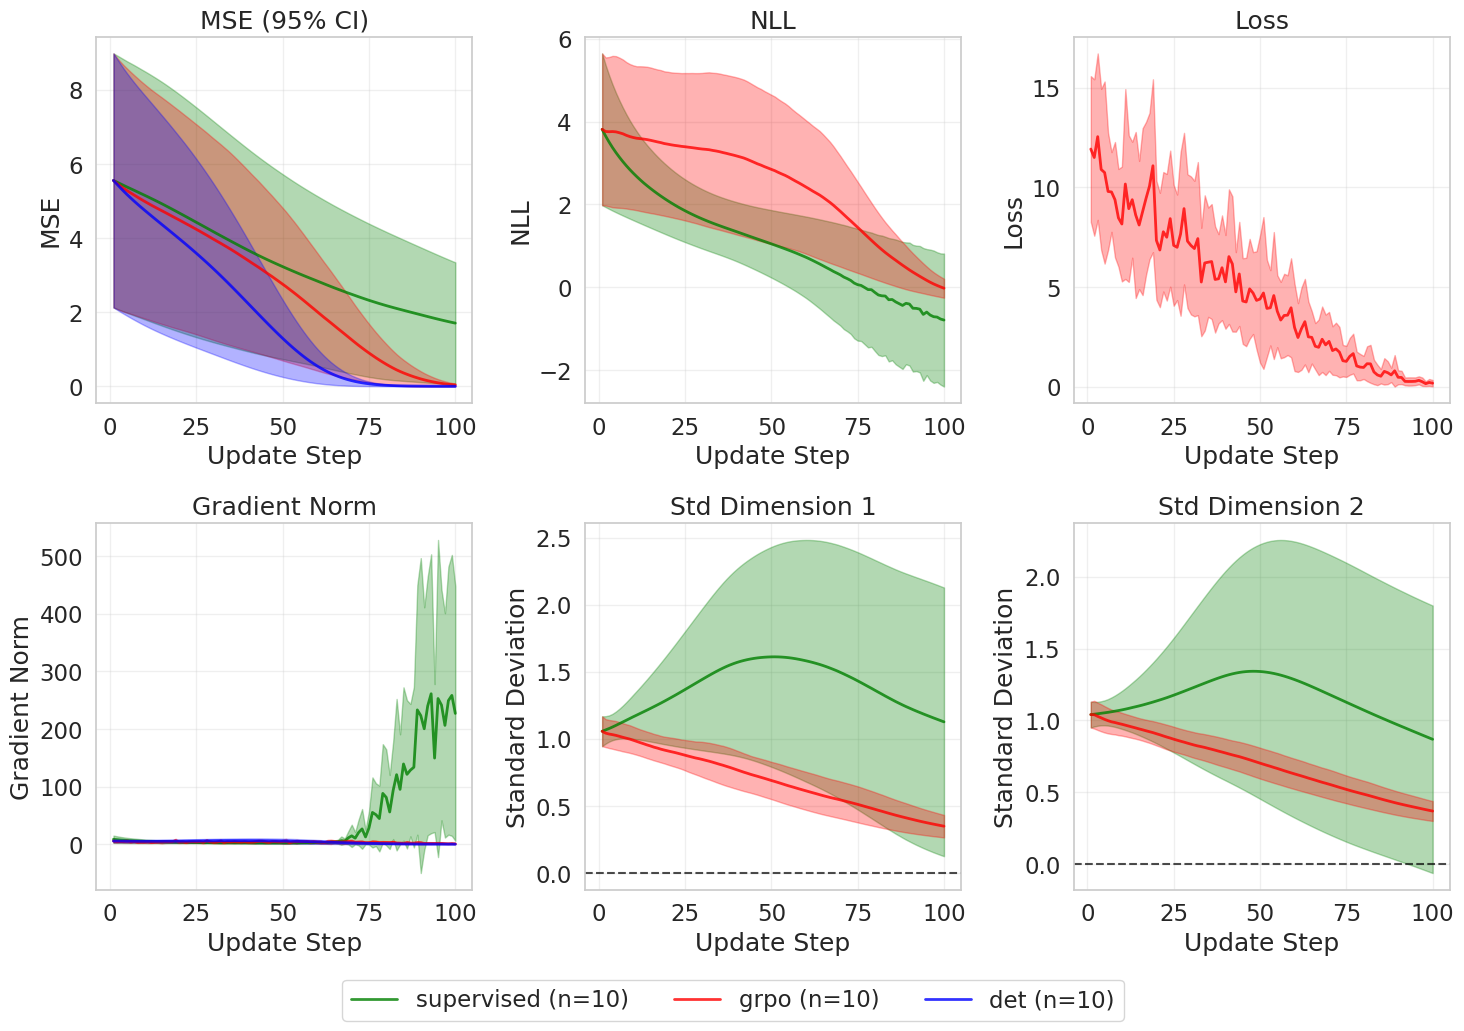

Completed 10 experiments!


In [47]:
# Plot results with confidence bounds
print("Plotting results with confidence bounds...")
plot_training_metrics_with_confidence(
    results_dict={
        "supervised": supervised_results_list,
        "grpo": grpo_results_list,
        "det": det_results_list,
    },
    gt_std=0.0 if init_dist_n_samples == 1 else init_dist_scale,
    confidence_level=0.95,
    figsize=(15, 10),
    colors={"supervised": "green", "grpo": "red", "det": "blue"},
    linewidth=2,
    alpha_line=0.8,
    alpha_fill=0.3,
    save_path=f"figures/{'fixed' if fixed_logstd else 'learned'}std_tr_loc-{init_dist_loc:.0f}_scale-{init_dist_scale:.0f}_stoch-target-{init_dist_n_samples}_n-updates-{n_updates}.png",
)
print(f"Completed {n_experiments} experiments!")

### gif

In [ ]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image, display


def create_grpo_gif(
    gif_path: str = "grpo_evolution.gif",
    n_updates_max: int = 100,
    freq: int = 10,
    n_samples: int = 1000,
    init_dist_loc: float = 1.0,
    init_dist_scale: float = 0.1,
    init_dist_n_samples: int = 1,
    n_generations_grpo: int = 5,
    sup_log_prob: bool = False,
    fixed_logstd: bool = True,
    input_dim: int = 4,
    output_dim: int = 2,
    hidden_sizes: List[int] = [64, 64],
):
    policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

    # generate input X
    X = torch.randn(1, input_dim)

    # initial model prediction
    mean, std = policy(X)
    init_dist = torch.distributions.Normal(mean, std)
    init_samples = init_dist.sample((n_samples,)).detach().numpy().squeeze()

    # generate target y
    mean_y = 2 + torch.randn(1, output_dim) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample

    # Set up the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Define the range of n_updates to animate
    n_updates_range = list(range(1, n_updates_max, freq))
    supervised, grpo = compare_dist(
        policy=policy,
        n_updates=n_updates_max,
        X=X,
        y=y,
        n_generations_grpo=n_generations_grpo,
        sup_log_prob=sup_log_prob,
    )

    def animate(frame):
        ax.clear()  # Clear the previous plot

        n_updates = n_updates_range[frame]

        # Get distributions for current n_updates
        supervised_dist = supervised["dist"][n_updates]
        grpo_dist = grpo["dist"][n_updates]
        samples = grpo["samples"][n_updates]

        plot_distributions_comparison(
            init_dist=init_dist,
            init_samples=init_samples,
            supervised_dist=supervised_dist,
            grpo_dist=grpo_dist,
            samples=samples,
            y=y,
            n_updates=n_updates,
            ax=ax,
            n_samples=n_samples,
        )

        print(f"Frame {frame + 1}/{len(n_updates_range)}: n_updates={n_updates}")

    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=len(n_updates_range), interval=200, repeat=True, blit=False
    )

    # Save as GIF
    writer = PillowWriter(fps=2)
    anim.save(gif_path, writer=writer)
    print(f"GIF saved as: {gif_path}")

    plt.close()
    return gif_path

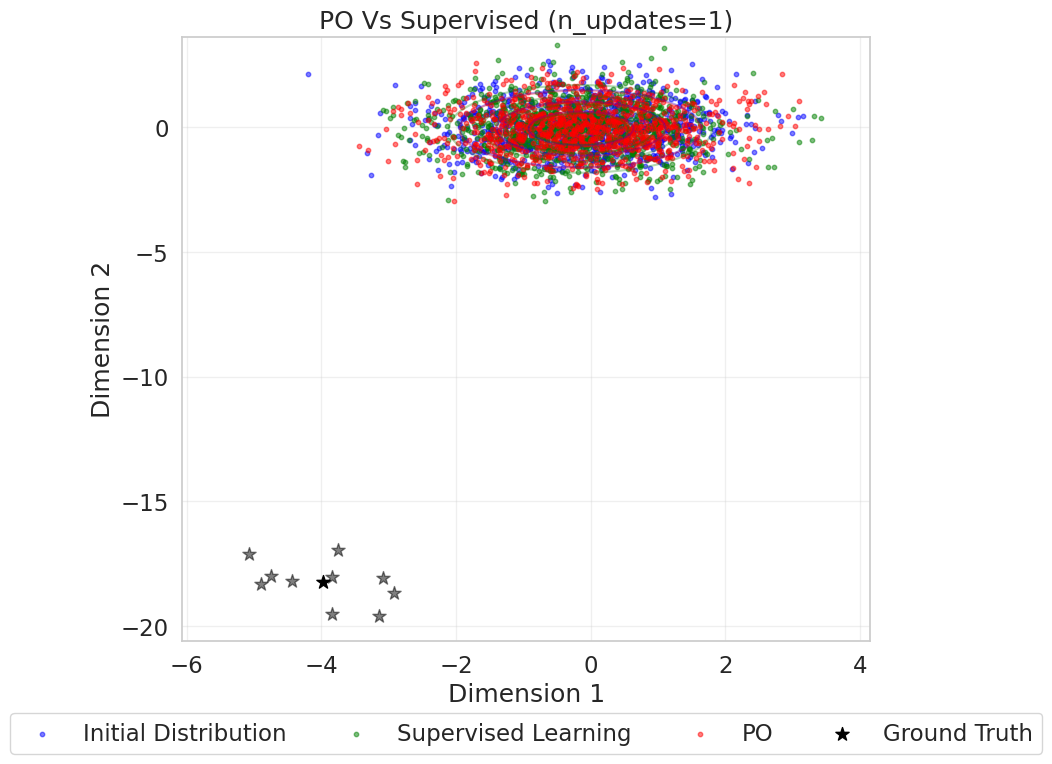

Frame 1/100: n_updates=1


<Figure size 640x480 with 0 Axes>

Frame 1/100: n_updates=1


<Figure size 640x480 with 0 Axes>

Frame 2/100: n_updates=6


<Figure size 640x480 with 0 Axes>

Frame 3/100: n_updates=11


<Figure size 640x480 with 0 Axes>

Frame 4/100: n_updates=16


<Figure size 640x480 with 0 Axes>

Frame 5/100: n_updates=21


<Figure size 640x480 with 0 Axes>

Frame 6/100: n_updates=26


<Figure size 640x480 with 0 Axes>

Frame 7/100: n_updates=31


<Figure size 640x480 with 0 Axes>

Frame 8/100: n_updates=36


<Figure size 640x480 with 0 Axes>

Frame 9/100: n_updates=41


<Figure size 640x480 with 0 Axes>

Frame 10/100: n_updates=46


<Figure size 640x480 with 0 Axes>

Frame 11/100: n_updates=51


<Figure size 640x480 with 0 Axes>

Frame 12/100: n_updates=56


<Figure size 640x480 with 0 Axes>

Frame 13/100: n_updates=61


<Figure size 640x480 with 0 Axes>

Frame 14/100: n_updates=66


<Figure size 640x480 with 0 Axes>

Frame 15/100: n_updates=71


<Figure size 640x480 with 0 Axes>

Frame 16/100: n_updates=76


<Figure size 640x480 with 0 Axes>

Frame 17/100: n_updates=81


<Figure size 640x480 with 0 Axes>

Frame 18/100: n_updates=86


<Figure size 640x480 with 0 Axes>

Frame 19/100: n_updates=91


<Figure size 640x480 with 0 Axes>

Frame 20/100: n_updates=96


<Figure size 640x480 with 0 Axes>

Frame 21/100: n_updates=101


<Figure size 640x480 with 0 Axes>

Frame 22/100: n_updates=106


<Figure size 640x480 with 0 Axes>

Frame 23/100: n_updates=111


<Figure size 640x480 with 0 Axes>

Frame 24/100: n_updates=116


<Figure size 640x480 with 0 Axes>

Frame 25/100: n_updates=121


<Figure size 640x480 with 0 Axes>

Frame 26/100: n_updates=126


<Figure size 640x480 with 0 Axes>

Frame 27/100: n_updates=131


<Figure size 640x480 with 0 Axes>

Frame 28/100: n_updates=136


<Figure size 640x480 with 0 Axes>

Frame 29/100: n_updates=141


<Figure size 640x480 with 0 Axes>

Frame 30/100: n_updates=146


<Figure size 640x480 with 0 Axes>

Frame 31/100: n_updates=151


<Figure size 640x480 with 0 Axes>

Frame 32/100: n_updates=156


<Figure size 640x480 with 0 Axes>

Frame 33/100: n_updates=161


<Figure size 640x480 with 0 Axes>

Frame 34/100: n_updates=166


<Figure size 640x480 with 0 Axes>

Frame 35/100: n_updates=171


<Figure size 640x480 with 0 Axes>

Frame 36/100: n_updates=176


<Figure size 640x480 with 0 Axes>

Frame 37/100: n_updates=181


<Figure size 640x480 with 0 Axes>

Frame 38/100: n_updates=186


<Figure size 640x480 with 0 Axes>

Frame 39/100: n_updates=191


<Figure size 640x480 with 0 Axes>

Frame 40/100: n_updates=196


<Figure size 640x480 with 0 Axes>

Frame 41/100: n_updates=201


<Figure size 640x480 with 0 Axes>

Frame 42/100: n_updates=206


<Figure size 640x480 with 0 Axes>

Frame 43/100: n_updates=211


<Figure size 640x480 with 0 Axes>

Frame 44/100: n_updates=216


<Figure size 640x480 with 0 Axes>

Frame 45/100: n_updates=221


<Figure size 640x480 with 0 Axes>

Frame 46/100: n_updates=226


<Figure size 640x480 with 0 Axes>

Frame 47/100: n_updates=231


<Figure size 640x480 with 0 Axes>

Frame 48/100: n_updates=236


<Figure size 640x480 with 0 Axes>

Frame 49/100: n_updates=241


<Figure size 640x480 with 0 Axes>

Frame 50/100: n_updates=246


<Figure size 640x480 with 0 Axes>

Frame 51/100: n_updates=251


<Figure size 640x480 with 0 Axes>

Frame 52/100: n_updates=256


<Figure size 640x480 with 0 Axes>

Frame 53/100: n_updates=261


<Figure size 640x480 with 0 Axes>

Frame 54/100: n_updates=266


<Figure size 640x480 with 0 Axes>

Frame 55/100: n_updates=271


<Figure size 640x480 with 0 Axes>

Frame 56/100: n_updates=276


<Figure size 640x480 with 0 Axes>

Frame 57/100: n_updates=281


<Figure size 640x480 with 0 Axes>

Frame 58/100: n_updates=286


<Figure size 640x480 with 0 Axes>

Frame 59/100: n_updates=291


<Figure size 640x480 with 0 Axes>

Frame 60/100: n_updates=296


<Figure size 640x480 with 0 Axes>

Frame 61/100: n_updates=301


<Figure size 640x480 with 0 Axes>

Frame 62/100: n_updates=306


<Figure size 640x480 with 0 Axes>

Frame 63/100: n_updates=311


<Figure size 640x480 with 0 Axes>

Frame 64/100: n_updates=316


<Figure size 640x480 with 0 Axes>

Frame 65/100: n_updates=321


<Figure size 640x480 with 0 Axes>

Frame 66/100: n_updates=326


<Figure size 640x480 with 0 Axes>

Frame 67/100: n_updates=331


<Figure size 640x480 with 0 Axes>

Frame 68/100: n_updates=336


<Figure size 640x480 with 0 Axes>

Frame 69/100: n_updates=341


<Figure size 640x480 with 0 Axes>

Frame 70/100: n_updates=346


<Figure size 640x480 with 0 Axes>

Frame 71/100: n_updates=351


<Figure size 640x480 with 0 Axes>

Frame 72/100: n_updates=356


<Figure size 640x480 with 0 Axes>

Frame 73/100: n_updates=361


<Figure size 640x480 with 0 Axes>

Frame 74/100: n_updates=366


<Figure size 640x480 with 0 Axes>

Frame 75/100: n_updates=371


<Figure size 640x480 with 0 Axes>

Frame 76/100: n_updates=376


<Figure size 640x480 with 0 Axes>

Frame 77/100: n_updates=381


<Figure size 640x480 with 0 Axes>

Frame 78/100: n_updates=386


<Figure size 640x480 with 0 Axes>

Frame 79/100: n_updates=391


<Figure size 640x480 with 0 Axes>

Frame 80/100: n_updates=396


<Figure size 640x480 with 0 Axes>

Frame 81/100: n_updates=401


<Figure size 640x480 with 0 Axes>

Frame 82/100: n_updates=406


<Figure size 640x480 with 0 Axes>

Frame 83/100: n_updates=411


<Figure size 640x480 with 0 Axes>

Frame 84/100: n_updates=416


<Figure size 640x480 with 0 Axes>

Frame 85/100: n_updates=421


<Figure size 640x480 with 0 Axes>

Frame 86/100: n_updates=426


<Figure size 640x480 with 0 Axes>

Frame 87/100: n_updates=431


<Figure size 640x480 with 0 Axes>

Frame 88/100: n_updates=436


<Figure size 640x480 with 0 Axes>

Frame 89/100: n_updates=441


<Figure size 640x480 with 0 Axes>

Frame 90/100: n_updates=446


<Figure size 640x480 with 0 Axes>

Frame 91/100: n_updates=451


<Figure size 640x480 with 0 Axes>

Frame 92/100: n_updates=456


<Figure size 640x480 with 0 Axes>

Frame 93/100: n_updates=461


<Figure size 640x480 with 0 Axes>

Frame 94/100: n_updates=466


<Figure size 640x480 with 0 Axes>

Frame 95/100: n_updates=471


<Figure size 640x480 with 0 Axes>

Frame 96/100: n_updates=476


<Figure size 640x480 with 0 Axes>

Frame 97/100: n_updates=481


<Figure size 640x480 with 0 Axes>

Frame 98/100: n_updates=486


<Figure size 640x480 with 0 Axes>

Frame 99/100: n_updates=491


<Figure size 640x480 with 0 Axes>

Frame 100/100: n_updates=496
GIF saved as: gif/learnedstd_tr_loc-7_scale-1_stoch-target-10.gif


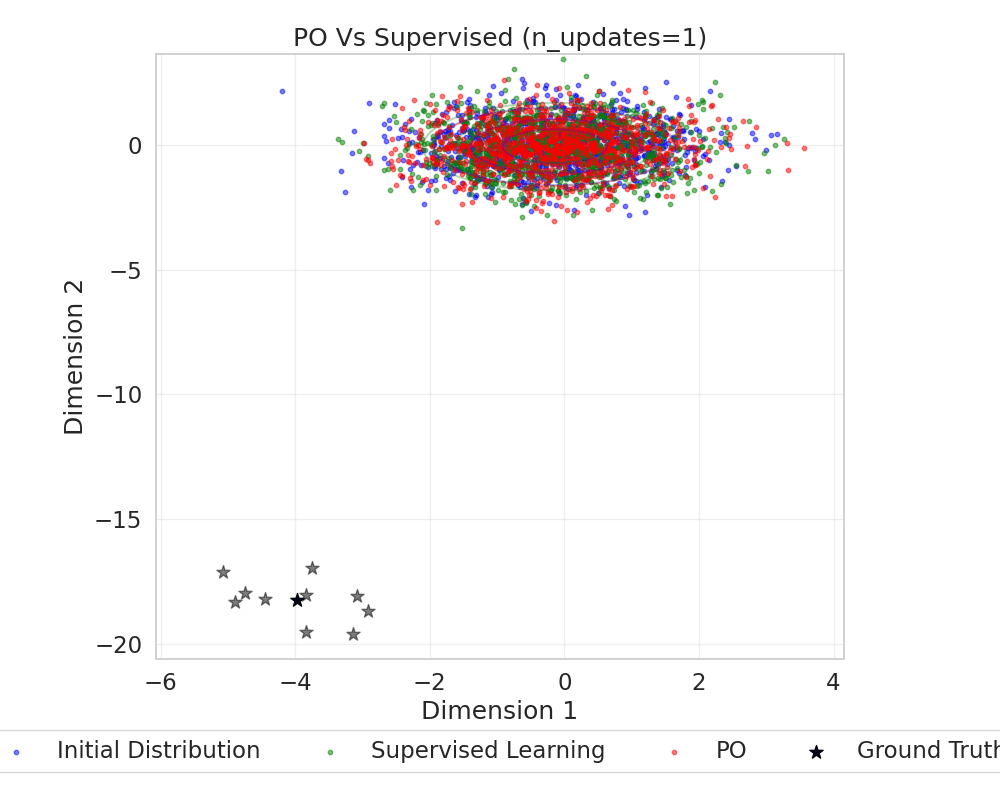

In [9]:
n_updates_max = 500
n_generations_grpo = 25

fixed_logstd = False
init_dist_loc = 7.0
init_dist_scale = 0.9
init_dist_n_samples = 10

gif_path = create_grpo_gif(
    gif_path=f"gif/{'fixed' if fixed_logstd else 'learned'}std_tr_loc-{init_dist_loc:.0f}_scale-{init_dist_scale:.0f}_stoch-target-{init_dist_n_samples}.gif",
    n_updates_max=n_updates_max,
    freq=5,
    n_samples=1000,
    n_generations_grpo=n_generations_grpo,
    sup_log_prob=True,
    fixed_logstd=fixed_logstd,
    init_dist_loc=init_dist_loc,
    init_dist_scale=init_dist_scale,
    init_dist_n_samples=init_dist_n_samples,
)
display(Image(filename=gif_path))

## Real world data

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

### load data

In [53]:
# 2. California Housing (1D output)
def create_california_housing_data():
    """Predict median house values in California districts"""
    housing = fetch_california_housing()
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(housing.data)
    y_scaled = scaler_y.fit_transform(housing.target.reshape(-1, 1))

    X_torch = torch.from_numpy(X_scaled.astype(np.float32))
    y_torch = torch.from_numpy(y_scaled.astype(np.float32))

    return X_torch, y_torch


# 3. Synthetic 2D output task - Robot arm control
def create_robot_arm_data(n_samples=100):
    """Predict end-effector position (x,y) from joint angles"""
    # 4 joint angles as input
    joint_angles = np.random.uniform(-np.pi, np.pi, (n_samples, 4))

    # Simple forward kinematics: end effector position
    L1, L2, L3, L4 = 1.0, 0.8, 0.6, 0.4  # link lengths

    x = (
        L1 * np.cos(joint_angles[:, 0])
        + L2 * np.cos(joint_angles[:, 0] + joint_angles[:, 1])
        + L3 * np.cos(joint_angles[:, 0] + joint_angles[:, 1] + joint_angles[:, 2])
        + L4
        * np.cos(
            joint_angles[:, 0]
            + joint_angles[:, 1]
            + joint_angles[:, 2]
            + joint_angles[:, 3]
        )
    )

    y = (
        L1 * np.sin(joint_angles[:, 0])
        + L2 * np.sin(joint_angles[:, 0] + joint_angles[:, 1])
        + L3 * np.sin(joint_angles[:, 0] + joint_angles[:, 1] + joint_angles[:, 2])
        + L4
        * np.sin(
            joint_angles[:, 0]
            + joint_angles[:, 1]
            + joint_angles[:, 2]
            + joint_angles[:, 3]
        )
    )

    end_effector_pos = np.column_stack([x, y])

    # Add some noise
    end_effector_pos += np.random.normal(0, 0.05, end_effector_pos.shape)

    X_torch = torch.from_numpy(joint_angles.astype(np.float32))
    y_torch = torch.from_numpy(end_effector_pos.astype(np.float32))

    return X_torch, y_torch


# Example usage with one of these datasets:
# X_real, y_real, scaler = create_robot_arm_data(n_samples=1)
# print(f"Input shape: {X_real.shape}, Output shape: {y_real.shape}")

### train test split

In [64]:
X, y = create_robot_arm_data(n_samples=10000)
# X, y = create_california_housing_data()
print(f"Input shape: {X.shape}, Output shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Select n random points from train and test datasets

n_train_samples = 5
train_indices = torch.randperm(X_train.size(0))[:n_train_samples]
X_train_sample = X_train[train_indices]
y_train_sample = y_train[train_indices]

n_test_samples = 3
test_indices = torch.randperm(X_test.size(0))[:n_test_samples]
X_test_sample = X_test[test_indices]
y_test_sample = y_test[test_indices]

print(f"Selected {n_train_samples} samples from train set: {X_train_sample.shape}")
print(f"Selected {n_test_samples} samples from test set: {X_test_sample.shape}")

Input shape: torch.Size([10000, 4]), Output shape: torch.Size([10000, 2])
X_train shape: torch.Size([6700, 4]), X_test shape: torch.Size([3300, 4])
Selected 5 samples from train set: torch.Size([5, 4])
Selected 3 samples from test set: torch.Size([3, 4])


### batch train test fn

In [65]:
def compare_dist_train_test(
    policy: MLPPolicy,
    X_train: torch.tensor,
    y_train: torch.tensor,
    X_test: torch.tensor,
    y_test: torch.tensor,
    n_updates: int = 1,
    n_generations_grpo: int = 5,
    learning_rate: float = 0.001,
    sup_log_prob: bool = True,
    rsample_for_grpo: bool = False,
):
    det_policy = copy.deepcopy(policy).train()
    supervised_policy = copy.deepcopy(policy).train()
    grpo_policy = copy.deepcopy(policy).train()

    det_optimizer = torch.optim.Adam(det_policy.parameters(), lr=learning_rate)
    supervised_optimizer = torch.optim.Adam(
        supervised_policy.parameters(), lr=learning_rate
    )
    grpo_optimizer = torch.optim.Adam(grpo_policy.parameters(), lr=learning_rate)

    # Pre-allocate arrays for training and test metrics
    det_results = {
        "train": {
            "grad_norm": torch.zeros(n_updates),
            "mean_error": torch.zeros(n_updates),
        },
        "test": {
            "mean_error": torch.zeros(n_updates),
        },
    }

    supervised_results = {
        "train": {
            "grad_norm": torch.zeros(n_updates),
            "mean_error": torch.zeros(n_updates),
            "NLL": torch.zeros(n_updates),
        },
        "test": {
            "mean_error": torch.zeros(n_updates),
            "NLL": torch.zeros(n_updates),
        },
    }

    grpo_results = {
        "train": {
            "grad_norm": torch.zeros(n_updates),
            "mean_error": torch.zeros(n_updates),
            "NLL": torch.zeros(n_updates),
            "loss": torch.zeros(n_updates),
        },
        "test": {
            "mean_error": torch.zeros(n_updates),
            "NLL": torch.zeros(n_updates),
        },
    }

    # Train deterministic policy
    for i in range(n_updates):
        det_policy.train()
        mean_train, _ = det_policy(X_train)
        loss = nn.MSELoss()(mean_train, y_train)

        det_optimizer.zero_grad()
        loss.backward()

        # Compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(
            det_policy.parameters(), max_norm=1e9
        )
        det_results["train"]["grad_norm"][i] = grad_norm
        det_results["train"]["mean_error"][i] = nn.MSELoss()(
            mean_train.mean(dim=0), y_train.mean(dim=0)
        )

        det_optimizer.step()

        # Evaluate on test set
        det_policy.eval()
        with torch.no_grad():
            mean_test, _ = det_policy(X_test)
            det_results["test"]["mean_error"][i] = nn.MSELoss()(
                mean_test.mean(dim=0), y_test.mean(dim=0)
            )

    # Train supervised policy
    for i in range(n_updates):
        supervised_policy.train()
        mean_train, std_train = supervised_policy(X_train)
        dist_train = torch.distributions.Normal(mean_train, std_train)

        if sup_log_prob:
            loss = -dist_train.log_prob(y_train).mean()
        else:
            pred = dist_train.rsample()
            loss = nn.MSELoss()(pred, y_train)

        supervised_optimizer.zero_grad()
        loss.backward()

        # Training metrics
        supervised_results["train"]["NLL"][i] = (
            -dist_train.log_prob(y_train).mean().item()
        )
        supervised_results["train"]["mean_error"][i] = nn.MSELoss()(
            mean_train.mean(dim=0), y_train.mean(dim=0)
        )

        # Compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(
            supervised_policy.parameters(), max_norm=1e9
        )
        supervised_results["train"]["grad_norm"][i] = grad_norm

        supervised_optimizer.step()

        # Evaluate on test set
        supervised_policy.eval()
        with torch.no_grad():
            mean_test, std_test = supervised_policy(X_test)
            dist_test = torch.distributions.Normal(mean_test, std_test)
            supervised_results["test"]["NLL"][i] = (
                -dist_test.log_prob(y_test).mean().item()
            )
            supervised_results["test"]["mean_error"][i] = nn.MSELoss()(
                mean_test.mean(dim=0), y_test.mean(dim=0)
            )

    # Train GRPO policy
    for i in range(n_updates):
        grpo_policy.train()
        mean_train, std_train = grpo_policy(X_train)
        dist_train = torch.distributions.Normal(mean_train, std_train)

        if rsample_for_grpo:
            samples = dist_train.rsample((n_generations_grpo,))
            rewards = -nn.MSELoss(reduction="none")(samples, y_train).mean(dim=-1)
            loss = -rewards.mean()
        else:
            samples = dist_train.sample((n_generations_grpo,))
            neg_log_prob = -dist_train.log_prob(samples).mean(dim=-1)
            rewards = -nn.MSELoss(reduction="none")(samples, y_train).mean(dim=-1)
            rewards_min, rewards_max = rewards.aminmax(dim=0, keepdim=True)
            rewards = rewards - rewards_min
            loss = (neg_log_prob * rewards).mean()

        grpo_optimizer.zero_grad()
        loss.backward()

        # Training metrics
        grpo_results["train"]["loss"][i] = loss.item()
        grpo_results["train"]["NLL"][i] = -dist_train.log_prob(y_train).mean().item()
        grpo_results["train"]["mean_error"][i] = nn.MSELoss()(
            mean_train.mean(dim=0), y_train.mean(dim=0)
        )

        # Compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(
            grpo_policy.parameters(), max_norm=1e9
        )
        grpo_results["train"]["grad_norm"][i] = grad_norm

        grpo_optimizer.step()

        # Evaluate on test set
        grpo_policy.eval()
        with torch.no_grad():
            mean_test, std_test = grpo_policy(X_test)
            dist_test = torch.distributions.Normal(mean_test, std_test)
            grpo_results["test"]["NLL"][i] = -dist_test.log_prob(y_test).mean().item()
            grpo_results["test"]["mean_error"][i] = nn.MSELoss()(
                mean_test.mean(dim=0), y_test.mean(dim=0)
            )

    return det_results, supervised_results, grpo_results


def run_repeated_experiments_train_test(
    X_train: torch.tensor,
    y_train: torch.tensor,
    X_test: torch.tensor,
    y_test: torch.tensor,
    n_experiments: int,
    n_updates: int = 100,
    input_dim: int = 4,
    output_dim: int = 2,
    hidden_sizes: List[int] = [64, 64],
    seed: int = None,
    n_generations_grpo: int = 5,
    learning_rate: float = 0.001,
    sup_log_prob: bool = True,
    fixed_logstd: bool = False,
    rsample_for_grpo: bool = False,
) -> Tuple[List[Dict], List[Dict]]:
    """
    Run the compare_dist experiment multiple times.

    Args:
        n_experiments: Number of experiments to run
        n_updates: Number of updates per experiment
        input_dim: Input dimension for the policy
        output_dim: Output dimension for the policy
        hidden_sizes: Hidden layer sizes for the policy
        seed: Random seed for reproducibility
        n_generations_grpo: Number of generations for GRPO
        learning_rate: Learning rate for optimizers
        sup_log_prob: Whether to use log probability for supervised learning

    Returns:
        supervised_results: List of supervised results from each experiment
        grpo_results: List of GRPO results from each experiment
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    det_results = []
    supervised_results = []
    grpo_results = []

    for _ in tqdm(range(n_experiments), desc="n_experiments"):
        # Create new policy for each experiment
        policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

        # Run comparison
        det, supervised, grpo = compare_dist_train_test(
            policy=policy,
            n_updates=n_updates,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            n_generations_grpo=n_generations_grpo,
            learning_rate=learning_rate,
            sup_log_prob=sup_log_prob,
            rsample_for_grpo=rsample_for_grpo,
        )

        supervised_results.append(supervised)
        grpo_results.append(grpo)
        det_results.append(det)

    return (
        det_results,
        supervised_results,
        grpo_results,
    )


def extract_metrics_statistics_train_test(
    results_list: List[Dict], metric: str, split: str = "train"
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract mean, std, and confidence intervals for a specific metric from train/test structure.

    Args:
        results_list: List of result dictionaries from multiple experiments
        metric: Metric name ('grad_norm', 'mean_error', 'NLL', 'loss')
        split: Either 'train' or 'test'

    Returns:
        mean_values: Mean values across experiments
        std_values: Standard deviation across experiments
        all_values: All values (n_experiments x n_updates)
    """
    # Convert to numpy arrays
    all_values = []
    for results in results_list:
        if split in results and metric in results[split]:
            metric_values = results[split][metric]
            # Convert tensors to numpy if needed
            if hasattr(metric_values[0], "detach"):
                metric_values = [
                    x.detach().numpy() if hasattr(x, "detach") else x
                    for x in metric_values
                ]
            all_values.append(metric_values)

    if not all_values:
        return None, None, None

    # Convert to numpy array (n_experiments x n_updates)
    all_values = np.array(all_values)

    # Calculate statistics
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)

    return mean_values, std_values, all_values


def plot_training_metrics_with_confidence_train_test(
    results_dict: Dict[str, List[Dict]],
    confidence_level: float = 0.95,
    figsize: Tuple[float, float] = (18, 10),
    colors: Dict[str, str] = None,
    linewidth: float = 2,
    alpha_line: float = 1.0,
    alpha_fill: float = 0.3,
    grid_alpha: float = 0.3,
    save_path_prefix: str = None,
    log_scale_grad: bool = False,
    log_scale_error: bool = False,
    log_scale_nll: bool = False,
    log_scale_loss: bool = False,
    show_plot: bool = True,
):
    """
    Plot training and test metrics with confidence bounds from multiple experiments.
    Creates separate figures for training and test data.

    Args:
        results_dict: Dictionary with method names as keys and lists of results as values
                     Each result should have 'train' and 'test' keys with metrics
        confidence_level: Confidence level for bounds (e.g., 0.95 for 95%)
        figsize: Figure size tuple
        colors: Dictionary with colors for each method (auto-generated if None)
        linewidth: Line width for mean lines
        alpha_line: Alpha for mean lines
        alpha_fill: Alpha for confidence intervals
        grid_alpha: Grid transparency
        save_path_prefix: Prefix for save paths (will add '_train.png' and '_test.png')
        log_scale_grad: Whether to use log scale for gradient norm plot
        log_scale_error: Whether to use log scale for mean error plot
        log_scale_nll: Whether to use log scale for NLL plot
        log_scale_loss: Whether to use log scale for loss plot
        show_plot: Whether to display the plots

    Returns:
        train_fig, test_fig, train_axes, test_axes: matplotlib figures and axes
    """
    # Default colors if not provided
    if colors is None:
        color_cycle = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))
        colors = {
            method: color for method, color in zip(results_dict.keys(), color_cycle)
        }

    # Calculate confidence interval multiplier
    from scipy import stats

    alpha = 1 - confidence_level
    n_experiments = len(next(iter(results_dict.values())))
    t_value = stats.t.ppf(1 - alpha / 2, n_experiments - 1)

    # Create figures for train and test
    train_fig, train_axes = plt.subplots(2, 2, figsize=figsize)
    test_fig, test_axes = plt.subplots(1, 2, figsize=(figsize[0], figsize[1] // 2))

    # Flatten axes for easier indexing
    train_ax1, train_ax2 = train_axes[0]  # First row: MSE, NLL
    train_ax3, train_ax4 = train_axes[1]  # Second row: Loss, Grad norm
    test_ax1, test_ax2 = test_axes.flatten()  # MSE, NLL

    # Process each split
    for split, fig, axes_dict in [
        (
            "train",
            train_fig,
            {
                "mean_error": train_ax1,
                "NLL": train_ax2,
                "loss": train_ax3,
                "grad_norm": train_ax4,
            },
        ),
        ("test", test_fig, {"mean_error": test_ax1, "NLL": test_ax2}),
    ]:
        # Extract statistics for all metrics and methods for this split
        metrics_data = {}
        for method_name, results_list in results_dict.items():
            metrics_data[method_name] = {}

            for metric in ["mean_error", "NLL", "loss", "grad_norm"]:
                mean_values, std_values, all_values = (
                    extract_metrics_statistics_train_test(results_list, metric, split)
                )
                if mean_values is not None:
                    ci_values = t_value * std_values / np.sqrt(n_experiments)
                    metrics_data[method_name][metric] = {
                        "mean": mean_values,
                        "std": std_values,
                        "ci": ci_values,
                        "all": all_values,
                    }

        # Create update indices
        n_updates = None
        for method_data in metrics_data.values():
            if "mean_error" in method_data:
                n_updates = len(method_data["mean_error"]["mean"])
                break

        if n_updates is None:
            continue

        updates = np.arange(1, n_updates + 1)

        # Plot metrics for this split
        for metric, ax in axes_dict.items():
            if metric in ["mean_error", "NLL", "loss", "grad_norm"]:
                # Plot each method
                for method_name, method_data in metrics_data.items():
                    if metric in method_data:
                        data = method_data[metric]
                        ax.plot(
                            updates,
                            data["mean"],
                            color=colors[method_name],
                            linewidth=linewidth,
                            alpha=alpha_line,
                            label=f"{method_name} (n={n_experiments})",
                        )
                        ax.fill_between(
                            updates,
                            data["mean"] - data["ci"],
                            data["mean"] + data["ci"],
                            color=colors[method_name],
                            alpha=alpha_fill,
                        )

                # Set labels and formatting
                ax.set_xlabel("Update Step")
                ax.grid(True, alpha=grid_alpha)

                if metric == "mean_error":
                    ax.set_ylabel("MSE")
                    ax.set_title(
                        f"MSE - {split.title()} ({confidence_level * 100:.0f}% CI)"
                    )
                    if log_scale_error:
                        ax.set_yscale("log")
                elif metric == "NLL":
                    ax.set_ylabel("NLL")
                    ax.set_title(f"NLL - {split.title()}")
                    if log_scale_nll:
                        ax.set_yscale("log")
                elif metric == "loss":
                    ax.set_ylabel("Loss")
                    ax.set_title(f"Loss - {split.title()}")
                    if log_scale_loss:
                        ax.set_yscale("log")
                elif metric == "grad_norm":
                    ax.set_ylabel("Gradient Norm")
                    ax.set_title(f"Gradient Norm - {split.title()}")
                    if log_scale_grad:
                        ax.set_yscale("log")

        # Add legend for this figure
        if split == "train":
            handles, labels = train_ax1.get_legend_handles_labels()
            train_fig.legend(
                handles,
                labels,
                loc="lower center",
                bbox_to_anchor=(0.5, -0.05),
                ncol=len(results_dict),
            )
        else:
            handles, labels = test_ax1.get_legend_handles_labels()
            test_fig.legend(
                handles,
                labels,
                loc="lower center",
                bbox_to_anchor=(0.5, -0.05),
                ncol=len(results_dict),
            )

        # Adjust layout
        fig.tight_layout()

        # Save if path provided
        if save_path_prefix:
            save_path = f"{save_path_prefix}_{split}.png"
            fig.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"Saved {split} plot to: {save_path}")

    # Show plots if requested
    if show_plot:
        plt.show()

    return train_fig, test_fig, train_axes, test_axes

### exp

In [68]:
# Experiment parameters
n_experiments = 10  # Number of repetitions
n_updates = 300
input_dim = 4
output_dim = 2
hidden_sizes = [64, 64]

fixed_logstd = True
rsample_for_grpo = True

# Run repeated experiments
print(f"Running {n_experiments} experiments...")
det_results_list, supervised_results_list, grpo_results_list = (
    run_repeated_experiments_train_test(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        n_experiments=n_experiments,
        n_updates=n_updates,
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_sizes=hidden_sizes,
        seed=42,
        sup_log_prob=True,
        fixed_logstd=fixed_logstd,
        n_generations_grpo=25,
        rsample_for_grpo=rsample_for_grpo,
    )
)

Running 10 experiments...


n_experiments: 100%|██████████| 10/10 [02:42<00:00, 16.21s/it]


Plotting results with confidence bounds...
Saved train plot to: figures/dataset_fixedstd_tr_loc-1_scale-0_stoch-target-1_n-updates-300_train.png
Saved test plot to: figures/dataset_fixedstd_tr_loc-1_scale-0_stoch-target-1_n-updates-300_test.png


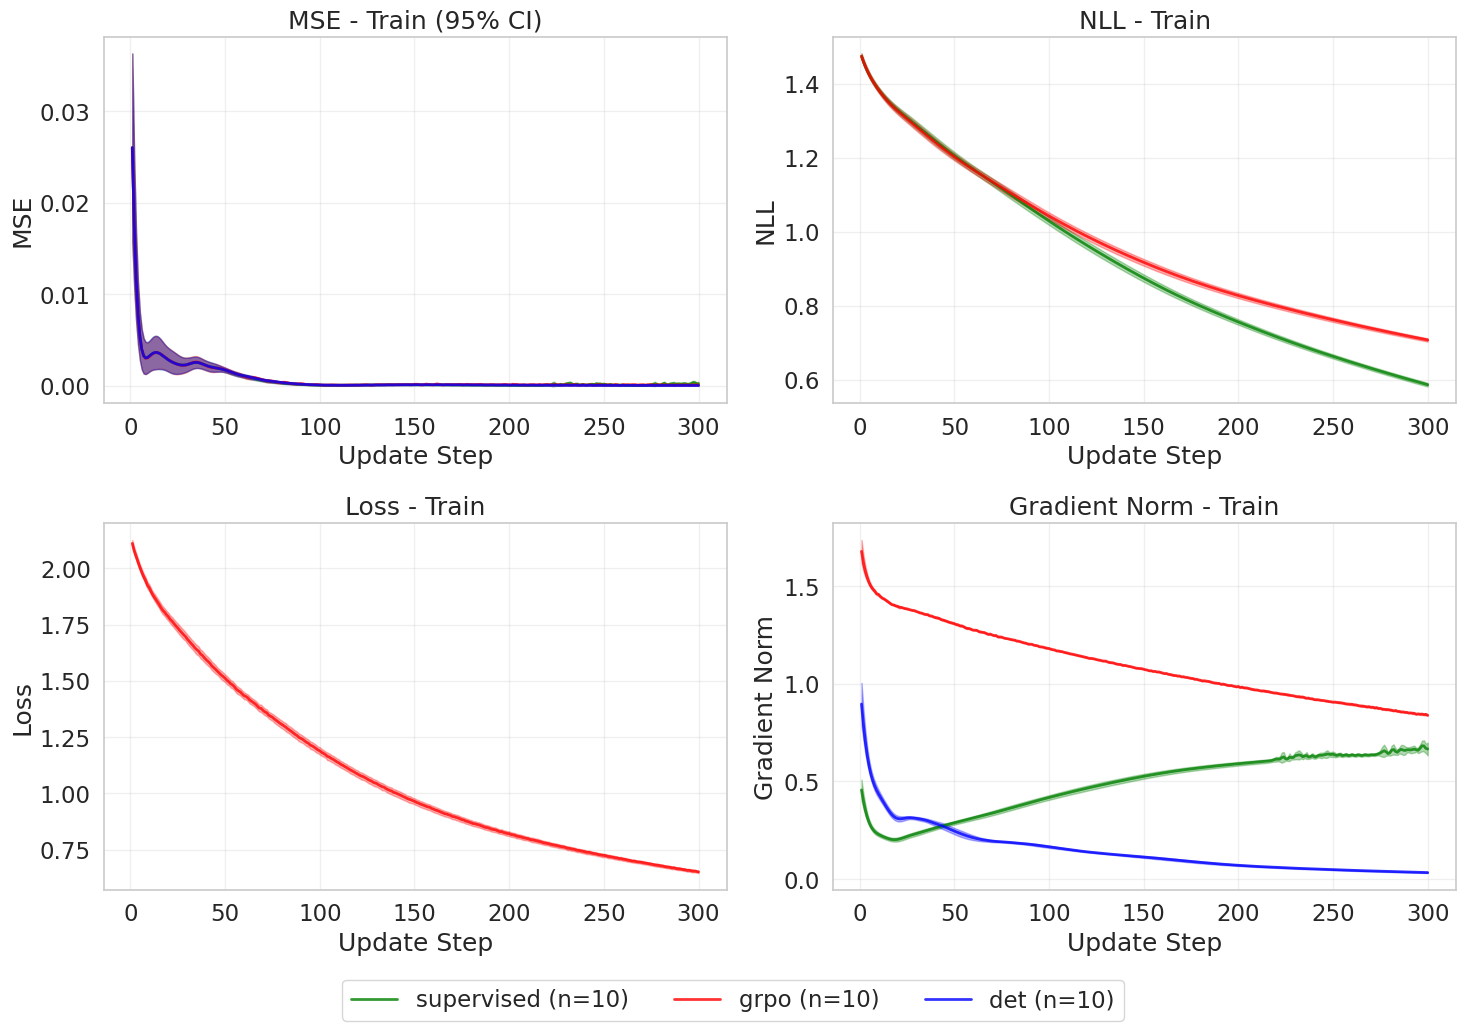

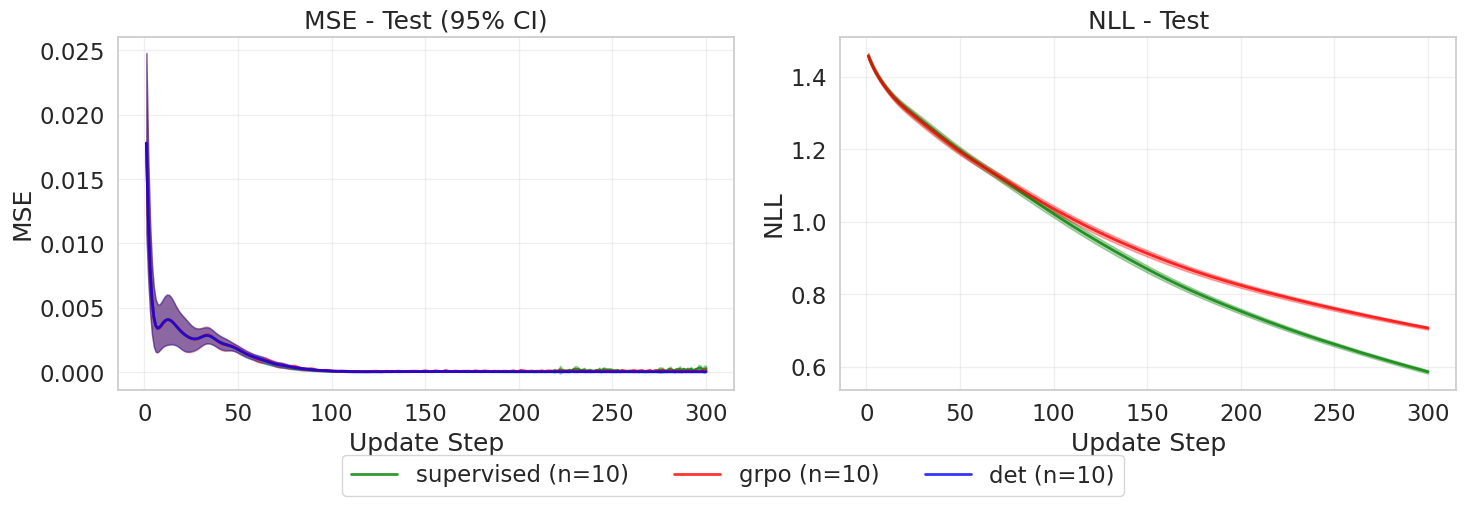

Completed 10 experiments!


In [69]:
# Plot results with confidence bounds
print("Plotting results with confidence bounds...")
plot_training_metrics_with_confidence_train_test(
    results_dict={
        "supervised": supervised_results_list,
        "grpo": grpo_results_list,
        "det": det_results_list,
    },
    confidence_level=0.95,
    figsize=(15, 10),
    colors={"supervised": "green", "grpo": "red", "det": "blue"},
    linewidth=2,
    alpha_line=0.8,
    alpha_fill=0.3,
    save_path_prefix=f"figures/dataset_{'fixed' if fixed_logstd else 'learned'}std_tr_loc-{init_dist_loc:.0f}_scale-{init_dist_scale:.0f}_stoch-target-{init_dist_n_samples}_n-updates-{n_updates}",
)
print(f"Completed {n_experiments} experiments!")

#### old code

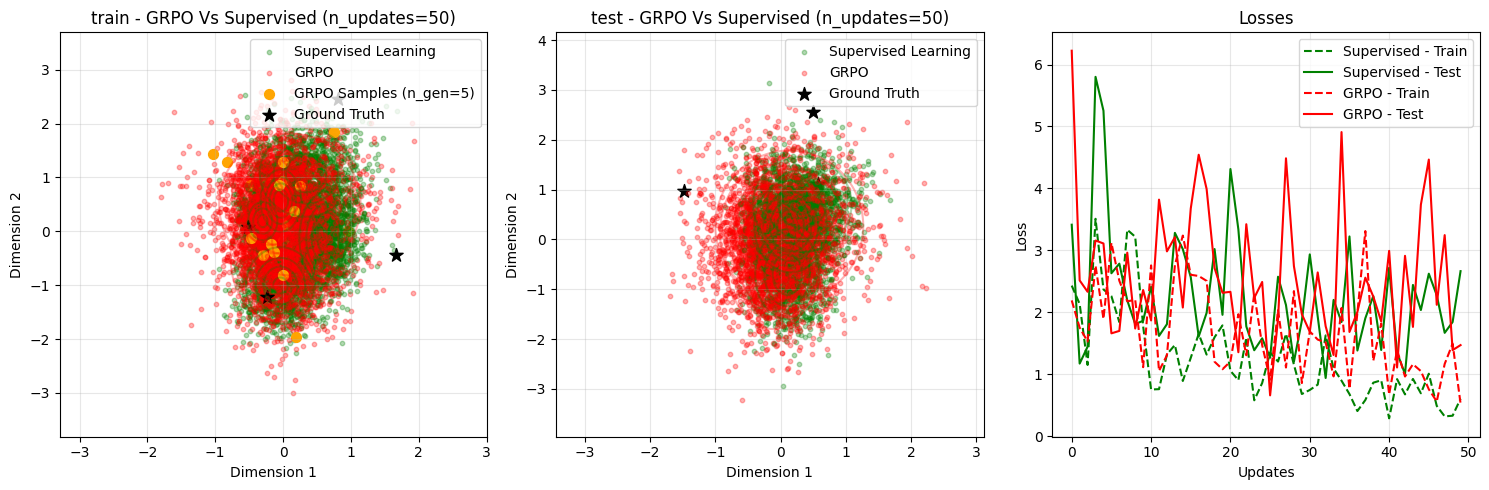

In [ ]:
n_updates = 50
input_dim = 4
output_dim = 2
hidden_sizes = [64, 64]
policy = MLPPolicy(input_dim, output_dim, hidden_sizes)

# initial model prediction
mean, std = policy(torch.cat([X_train_sample, X_test_sample], dim=0))
init_dist = D.Independent(D.Normal(mean, std), reinterpreted_batch_ndims=1)
supervised, grpo, samples_list, losses = batch_compare_dist(
    policy=policy,
    n_updates=n_updates,
    X_train=X_train_sample,
    y_train=y_train_sample,
    X_test=X_test_sample,
    y_test=y_test_sample,
)

idx = -1

# Create a 2D plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

n_samples = 1000
init_samples_allsq = init_dist.sample((n_samples,)).detach().numpy().squeeze()

for ax_idx, mode in enumerate(["train", "test"]):
    sample_size = len(eval(f"X_{mode}_sample"))
    if mode == "train":
        init_samples_all = init_samples_allsq[:, : len(X_train_sample)]
    else:
        init_samples_all = init_samples_allsq[:, len(X_train_sample) :]
    sup_samples_all = (
        supervised[mode][idx].sample((n_samples,)).detach().numpy().squeeze()
    )
    grpo_samples_all = grpo[mode][idx].sample((n_samples,)).detach().numpy().squeeze()

    for example in range(sample_size):
        init_samples = init_samples_all[:, example, :]
        sup_samples = sup_samples_all[:, example, :]
        grpo_samples = grpo_samples_all[:, example, :]
        if mode == "train":
            samples_np = (
                samples_list[mode][idx][:, example, :].detach().numpy().reshape(-1, 2)
            )
        supervised_dist = supervised[mode][idx]
        grpo_dist = grpo[mode][idx]

        if example == 0:
            # Plot initial distribution
            ax[ax_idx].scatter(
                init_samples[:, 0],
                init_samples[:, 1],
                c="blue",
                s=10,
                alpha=0.1,
                label="Initial Distribution" if example == 0 else None,
            )
            # Generate grid for contour plots
            x_range = np.linspace(
                np.min(init_samples[:, 0]), np.max(init_samples[:, 0]), 100
            )
            y_range = np.linspace(
                np.min(init_samples[:, 1]), np.max(init_samples[:, 1]), 100
            )
            X_grid, Y_grid = np.meshgrid(x_range, y_range)
            pos = np.dstack((X_grid, Y_grid))
            init_mean = init_dist.mean[example].detach().numpy().flatten()
            init_cov = torch.diag(
                init_dist.stddev[example].detach().flatten() ** 2
            ).numpy()
            init_rv = multivariate_normal(init_mean, init_cov)
            ax[ax_idx].contour(
                X_grid, Y_grid, init_rv.pdf(pos), colors="blue", alpha=0.3, levels=4
            )

        # Plot supervised learning distribution
        ax[ax_idx].scatter(
            sup_samples[:, 0],
            sup_samples[:, 1],
            c="green",
            s=10,
            alpha=0.3,
            label="Supervised Learning" if example == 0 else None,
        )
        # Generate grid for contour plots
        x_range = np.linspace(np.min(sup_samples[:, 0]), np.max(sup_samples[:, 0]), 100)
        y_range = np.linspace(np.min(sup_samples[:, 1]), np.max(sup_samples[:, 1]), 100)
        X_grid, Y_grid = np.meshgrid(x_range, y_range)
        pos = np.dstack((X_grid, Y_grid))
        sup_mean = supervised_dist.mean[example].detach().numpy().flatten()
        sup_cov = torch.diag(
            supervised_dist.stddev[example].detach().flatten() ** 2
        ).numpy()
        sup_rv = multivariate_normal(sup_mean, sup_cov)
        ax[ax_idx].contour(
            X_grid, Y_grid, sup_rv.pdf(pos), colors="green", alpha=0.3, levels=4
        )

        # Plot GRPO distribution
        ax[ax_idx].scatter(
            grpo_samples[:, 0],
            grpo_samples[:, 1],
            c="red",
            s=10,
            alpha=0.3,
            label="GRPO" if example == 0 else None,
        )
        # Generate grid for contour plots
        x_range = np.linspace(
            np.min(grpo_samples[:, 0]), np.max(grpo_samples[:, 0]), 100
        )
        y_range = np.linspace(
            np.min(grpo_samples[:, 1]), np.max(grpo_samples[:, 1]), 100
        )
        X_grid, Y_grid = np.meshgrid(x_range, y_range)
        pos = np.dstack((X_grid, Y_grid))
        grpo_mean = grpo_dist.mean[example].detach().numpy().flatten()
        grpo_cov = torch.diag(grpo_dist.stddev[example].detach().flatten() ** 2).numpy()
        grpo_rv = multivariate_normal(grpo_mean, grpo_cov)
        ax[ax_idx].contour(
            X_grid, Y_grid, grpo_rv.pdf(pos), colors="red", alpha=0.3, levels=4
        )

        if mode == "train":
            # Plot GRPO samples
            ax[ax_idx].scatter(
                samples_np[:, 0],
                samples_np[:, 1],
                c="orange",
                s=50,
                alpha=0.99,
                label="GRPO Samples (n_gen=5)" if example == 0 else None,
            )

        # Plot ground truth
        if mode == "train":
            y_np = y_train_sample[example].detach().numpy().flatten()
        else:
            y_np = y_test_sample[example].detach().numpy().flatten()
        ax[ax_idx].scatter(
            y_np[0],
            y_np[1],
            c="black",
            s=100,
            marker="*",
            label="Ground Truth" if example == 0 else None,
        )

    ax[ax_idx].set_title(f"{mode} - GRPO Vs Supervised (n_updates={n_updates})")
    ax[ax_idx].set_xlabel("Dimension 1")
    ax[ax_idx].set_ylabel("Dimension 2")
    ax[ax_idx].legend(loc="upper right")
    ax[ax_idx].grid(True, alpha=0.3)
    ax[ax_idx].set_xlim(
        np.min(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 0]
        ),
        np.max(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 0]
        ),
    )
    ax[ax_idx].set_ylim(
        np.min(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 1]
        ),
        np.max(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 1]
        ),
    )

# plot losses
ax[-1].plot(
    range(n_updates),
    losses["train"]["supervised"],
    label="Supervised - Train",
    color="green",
    linestyle="--",
)
ax[-1].plot(
    range(n_updates),
    losses["test"]["supervised"],
    label="Supervised - Test",
    color="green",
)
ax[-1].plot(
    range(n_updates),
    losses["train"]["grpo"],
    label="GRPO - Train",
    color="red",
    linestyle="--",
)
ax[-1].plot(
    range(n_updates),
    losses["test"]["grpo"],
    label="GRPO - Test",
    color="red",
)
ax[-1].set_title("Losses")
ax[-1].set_xlabel("Updates")
ax[-1].set_ylabel("Loss")
ax[-1].legend()
ax[-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# The End

y_test_sample

y_test_sample

In [ ]:
y_test_sample.shape

torch.Size([5, 2])

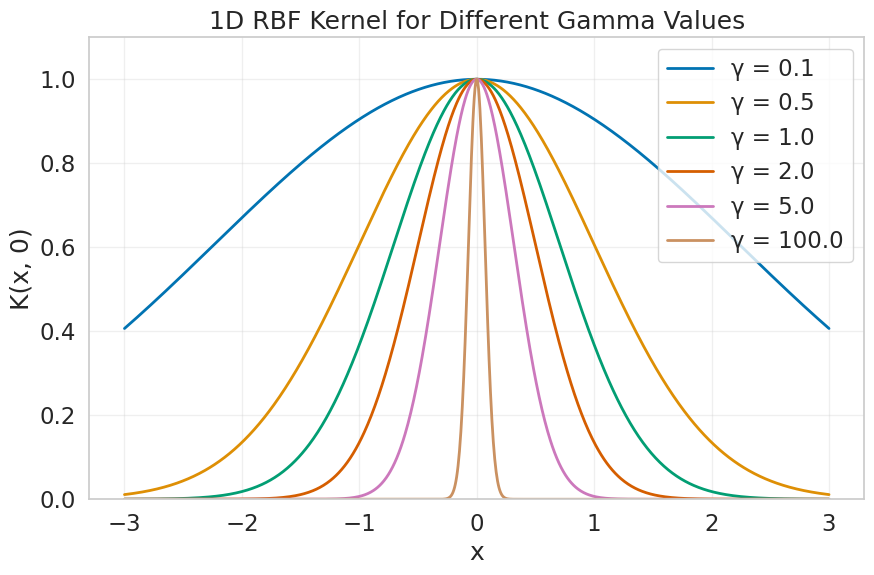

In [28]:
def rbf_kernel_1d(x, gamma):
    """
    Compute RBF (Gaussian) kernel for 1D input
    K(x, 0) = exp(-gamma * x^2)
    """
    return np.exp(-gamma * x**2)


# Create x values
x = np.linspace(-3, 3, 1000)

# Different gamma values
gamma_values = [0.1, 0.5, 1.0, 2.0, 5.0, 100.0]

# Create the plot
plt.figure(figsize=(10, 6))

for gamma in gamma_values:
    y = rbf_kernel_1d(x, gamma)
    plt.plot(x, y, linewidth=2, label=f"γ = {gamma}")

plt.xlabel("x")
plt.ylabel("K(x, 0)")
plt.title("1D RBF Kernel for Different Gamma Values")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)
plt.show()

In [ ]:
def compare_dist(
    policy: MLPPolicy,
    X: torch.tensor,
    y: torch.tensor,
    n_updates: int = 1,
    n_generations_grpo: int = 5,
    learning_rate: float = 0.001,
    sup_log_prob: bool = True,
    rsample_for_grpo: bool = False,
):
    det_policy = copy.deepcopy(policy).train()
    supervised_policy = copy.deepcopy(policy).train()
    po_policy = copy.deepcopy(policy).train()

    det_optimizer = torch.optim.Adam(det_policy.parameters(), lr=learning_rate)
    supervised_optimizer = torch.optim.Adam(
        supervised_policy.parameters(), lr=learning_rate
    )
    po_optimizer = torch.optim.Adam(po_policy.parameters(), lr=learning_rate)

    # train deterministic policy
    for _ in range(n_updates):
        mean, _ = det_policy(X)
        # Only use mean for deterministic policy, ignore std
        loss = nn.MSELoss()(mean, y)

        det_optimizer.zero_grad()
        loss.backward()

        det_optimizer.step()

    # train supervised (maximum likelihood estimation)
    for _ in range(n_updates):
        mean, std = supervised_policy(X)
        dist = torch.distributions.Normal(mean, std)
        if sup_log_prob:
            loss = -dist.log_prob(y).mean()
        else:
            pred = dist.rsample()
            loss = nn.MSELoss(reduction="none")(pred, y).mean(dim=-1)

        supervised_optimizer.zero_grad()
        loss.backward()

        supervised_optimizer.step()

    # train policy optimization
    for _ in range(n_updates):
        mean, std = po_policy(X)
        dist = torch.distributions.Normal(mean, std)
        if rsample_for_grpo:
            samples = dist.rsample((n_generations_grpo,))
            # rewards
            rewards = -nn.MSELoss(reduction="none")(samples, y).mean(dim=-1)
            # rewards_min, rewards_max = rewards.aminmax(dim=0, keepdim=True)
            # rewards = (rewards - rewards_min) # / (rewards_max - rewards_min)
            # loss fn
            loss = -rewards.mean()
        else:
            samples = dist.sample((n_generations_grpo,))
            # likelihood
            neg_log_prob = -dist.log_prob(samples).mean(dim=-1)
            # rewards
            rewards = -nn.MSELoss(reduction="none")(samples, y).mean(dim=-1)
            rewards_min, _ = rewards.aminmax(dim=0, keepdim=True)
            rewards = rewards - rewards_min  # / (rewards_max - rewards_min)
            # loss fn
            loss = (neg_log_prob * rewards).mean()

        po_optimizer.zero_grad()
        loss.backward()

        po_optimizer.step()

    return